# Rt profile multicategorical versus uniform

In [10]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import stan
import arviz as az
import nest_asyncio
import seaborn as sns
nest_asyncio.apply()

num_timepoints = 30 # number of days for incidence data
num_categories = 2

## Parameterize example branching process model with disagregated data

In [11]:
# Build the serial interval w_s
ws_mean = 15.3
ws_var = 9.3**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 0.1
serial_interval = disc_w

# contact_matrix = contact_matrix
contact_matrix = np.array([[11, 0.34], [3.41, 4]])
# contact_matrix = 1 * np.ones((2, 2))

transmissibility = [1, 0.5]
# transmissibility = [1.5, 1.5]

m = branchpro.MultiCatPoissonBranchProModel(
    initial_r, serial_interval, num_categories, contact_matrix, transmissibility)
new_rs = [0.088, 0.088]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = [50, 150] # initial number of cases
times = np.arange(num_timepoints)

desagg_cases = m.simulate(parameters, times, var_contacts=True)
agg_cases = np.sum(desagg_cases, axis=1)

print(desagg_cases)

[[ 50. 150.]
 [  0.   0.]
 [  2.   1.]
 [  1.   1.]
 [  4.   0.]
 [  0.   1.]
 [  2.   0.]
 [  3.   3.]
 [  5.   0.]
 [  3.   4.]
 [  3.   2.]
 [  2.   0.]
 [  6.   2.]
 [  4.   5.]
 [  3.   2.]
 [  7.   2.]
 [  8.   2.]
 [  1.   1.]
 [  3.   3.]
 [  2.   1.]
 [  5.   4.]
 [  6.   6.]
 [  2.   2.]
 [  4.   3.]
 [  5.   4.]
 [  2.   4.]
 [  3.   3.]
 [  3.   2.]
 [  0.   7.]
 [  1.   1.]]


## Plot agreggated local incidence numbers

In [12]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=agg_cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## R_t inference using STAN

In [13]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

# Correction for reproduction number per category
correc_i = np.multiply(np.sum(contact_matrix, axis=0), transmissibility)
correc_e = np.multiply(np.sum(m.exact_contact_matrix, axis=1), transmissibility)

In [14]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = []
for j in range(num_categories):
    ground_truth.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'R_t': (new_rs[0]*correc_e[R_t_start:(start_times[1]+1), j]).tolist() + (new_rs[1]*correc_e[(start_times[1]+1):num_timepoints, j]).tolist()
    }))

In [15]:
poisson_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_1466/1887272557.py:54: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [16]:
posterior = stan.build(
    poisson_model, data=poisson_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   5% (301/6000)
Sampling:   8% (500/6000)
Sampling:  12% (700/6000)
Sampling:  15% (900/6000)
Sampling:  18% (1100/6000)
Sampling:  22% (1300/6000)
Sampling:  25% (1500/6000)
Sampling:  28% (1700/6000)
Sampling:  32% (1900/6000)
Sampling:  35% (2100/6000)
Sampling:  38% (2300/6000)
Sampling:  42% (2500/6000)
Sampling:  62% (3700/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000205 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.05 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   0.557  0.127   0.329    0.789      0.002    0.001    6026.0    2089.0   
R[1]   0.536  0.110   0.334    0.742      0.002    0.001    5403.0    2223.0   
R[2]   0.508  0.097   0.343    0.697      0.001    0.001    6005.0    2293.0   
R[3]   0.486  0.086   0.324    0.640      0.001    0.001    5341.0    2268.0   
R[4]   0.409  0.074   0.269    0.544      0.001    0.001    5347.0    1829.0   
R[5]   0.475  0.079   0.326    0.622      0.001    0.001    5988.0    1967.0   
R[6]   0.539  0.082   0.368    0.676      0.001    0.001    5819.0    2048.0   
R[7]   0.514  0.080   0.369    0.664      0.001    0.001    5696.0    2332.0   
R[8]   0.555  0.081   0.405    0.708      0.001    0.001    4892.0    2358.0   
R[9]   0.592  0.085   0.426    0.742      0.001    0.001    5802.0    1986.0   
R[10]  0.559  0.082   0.409    0.707      0.001    0.001    4018.0    2116.0   
R[11]  0.615  0.083   0.456    0.763      0.001    0.001    4964.0    2295.0   
R[12]  0.563  0.086   0.403    0.729      0.001    0.001    5960.0    1977.0   
R[13]  0.575  0.086   0.422    0.736      0.001    0.001    4618.0    2067.0   
R[14]  0.679  0.092   0.521    0.866      0.001    0.001    5981.0    2443.0   
R[15]  0.629  0.090   0.464    0.795      0.001    0.001    6100.0    2214.0   
R[16]  0.605  0.093   0.444    0.793      0.001    0.001    6046.0    1847.0   
R[17]  0.720  0.102   0.531    0.906      0.001    0.001    5081.0    2122.0   
R[18]  0.737  0.102   0.546    0.923      0.001    0.001    4685.0    2126.0   
R[19]  0.800  0.111   0.608    1.024      0.001    0.001    6169.0    1811.0   
R[20]  0.761  0.108   0.569    0.970      0.002    0.001    4964.0    2270.0   
R[21]  0.698  0.106   0.504    0.896      0.002    0.001    4635.0    2147.0   
R[22]  0.682  0.105   0.476    0.858      0.001    0.001    5968.0    2107.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

In [17]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

In [19]:
fig = ReproductionNumberPlot()

for j in range(num_categories):
    fig.add_ground_truth_rt(ground_truth[j], shape=[None, 'dash'][j])
fig.add_interval_rt(pois_intervals, colour='deepskyblue', model_type='1-category Poisson')
fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.figure.add_hline(
    y=1, line_dash='dot',
    annotation_text='R=1', fillcolor='black',
    annotation_position='top right')

fig.figure.update_layout(
    width=900, 
    height=500,
    font=dict(
            size=16),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
)

fig.figure.write_image('images/Figure 2.pdf')

fig.show_figure()

## 1. Perfect Contact Tracing + Desaggregated data + Poisson Branching process with multiple categories

In [6]:
exact_multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int i, int t, array [,] real aI, array [] real aSI,
        array [,,] real C, array [] real transm) {
            real mean;

            mean = 0;
            for(j in 1:n){
                if(t > S) {
                    mean += C[t,i,j] * transm[j] * (
                        dot_product(aI[(t-S):(t-1), j], aSI) /
                        normalizing_const(aSI));
                }
                else {
                    mean += C[t,i,j] * transm[j] * (
                        dot_product(aI[:(t-1), j], aSI[(S-t+2):]) /
                        normalizing_const(aSI));
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [N, n, n] real C; // contact matrix
    array [n] real transm; // transmissibility vector
    array [N, n] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for (i in 1:n){
            for(k in (t-tau+1):(t+1)) {
                if (effective_no_infectives(N, S, n, i, k, I, revSI, C, transm) != 0) {
                    I[k, i] ~ poisson (
                        R[t-tau] * effective_no_infectives(
                            N, S, n, i, k, I, revSI, C, transm)); // likelihood
                        }
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

exact_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': np.array(m.exact_contact_matrix),
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_6899/2203937616.py:67: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [7]:
posterior = stan.build(
    exact_multicat_model, data=exact_multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   0.254  0.046   0.175    0.348      0.001      0.0    6902.0    2229.0   
R[1]   0.217  0.039   0.141    0.287      0.000      0.0    6498.0    1794.0   
R[2]   0.230  0.036   0.166    0.296      0.000      0.0    8515.0    2343.0   
R[3]   0.215  0.032   0.157    0.278      0.000      0.0    7044.0    1868.0   
R[4]   0.246  0.031   0.189    0.302      0.000      0.0    7910.0    2089.0   
R[5]   0.248  0.031   0.191    0.306      0.000      0.0    6514.0    2193.0   
R[6]   0.234  0.029   0.180    0.289      0.000      0.0    6725.0    2105.0   
R[7]   0.239  0.028   0.186    0.290      0.000      0.0    8324.0    1853.0   
R[8]   0.260  0.028   0.207    0.310      0.000      0.0    5913.0    2183.0   
R[9]   0.205  0.023   0.161    0.246      0.000      0.0    7308.0    2192.0   
R[10]  0.180  0.021   0.143    0.222      0.000      0.0    6256.0    1927.0   
R[11]  0.143  0.018   0.109    0.178      0.000      0.0    6457.0    2002.0   
R[12]  0.106  0.016   0.077    0.135      0.000      0.0    6541.0    1814.0   
R[13]  0.092  0.015   0.066    0.120      0.000      0.0    5975.0    1938.0   
R[14]  0.057  0.012   0.036    0.078      0.000      0.0    6136.0    2099.0   
R[15]  0.033  0.008   0.018    0.048      0.000      0.0    6658.0    2150.0   
R[16]  0.035  0.009   0.019    0.052      0.000      0.0    8240.0    2364.0   
R[17]  0.036  0.009   0.019    0.053      0.000      0.0    7220.0    1983.0   
R[18]  0.028  0.008   0.014    0.042      0.000      0.0    5756.0    1957.0   
R[19]  0.032  0.009   0.016    0.048      0.000      0.0    7560.0    2240.0   
R[20]  0.028  0.008   0.013    0.043      0.000      0.0    6555.0    2153.0   
R[21]  0.021  0.007   0.008    0.035      0.000      0.0    5405.0    1938.0   
R[22]  0.016  0.007   0.005    0.029      0.000      0.0    5746.0    1995.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

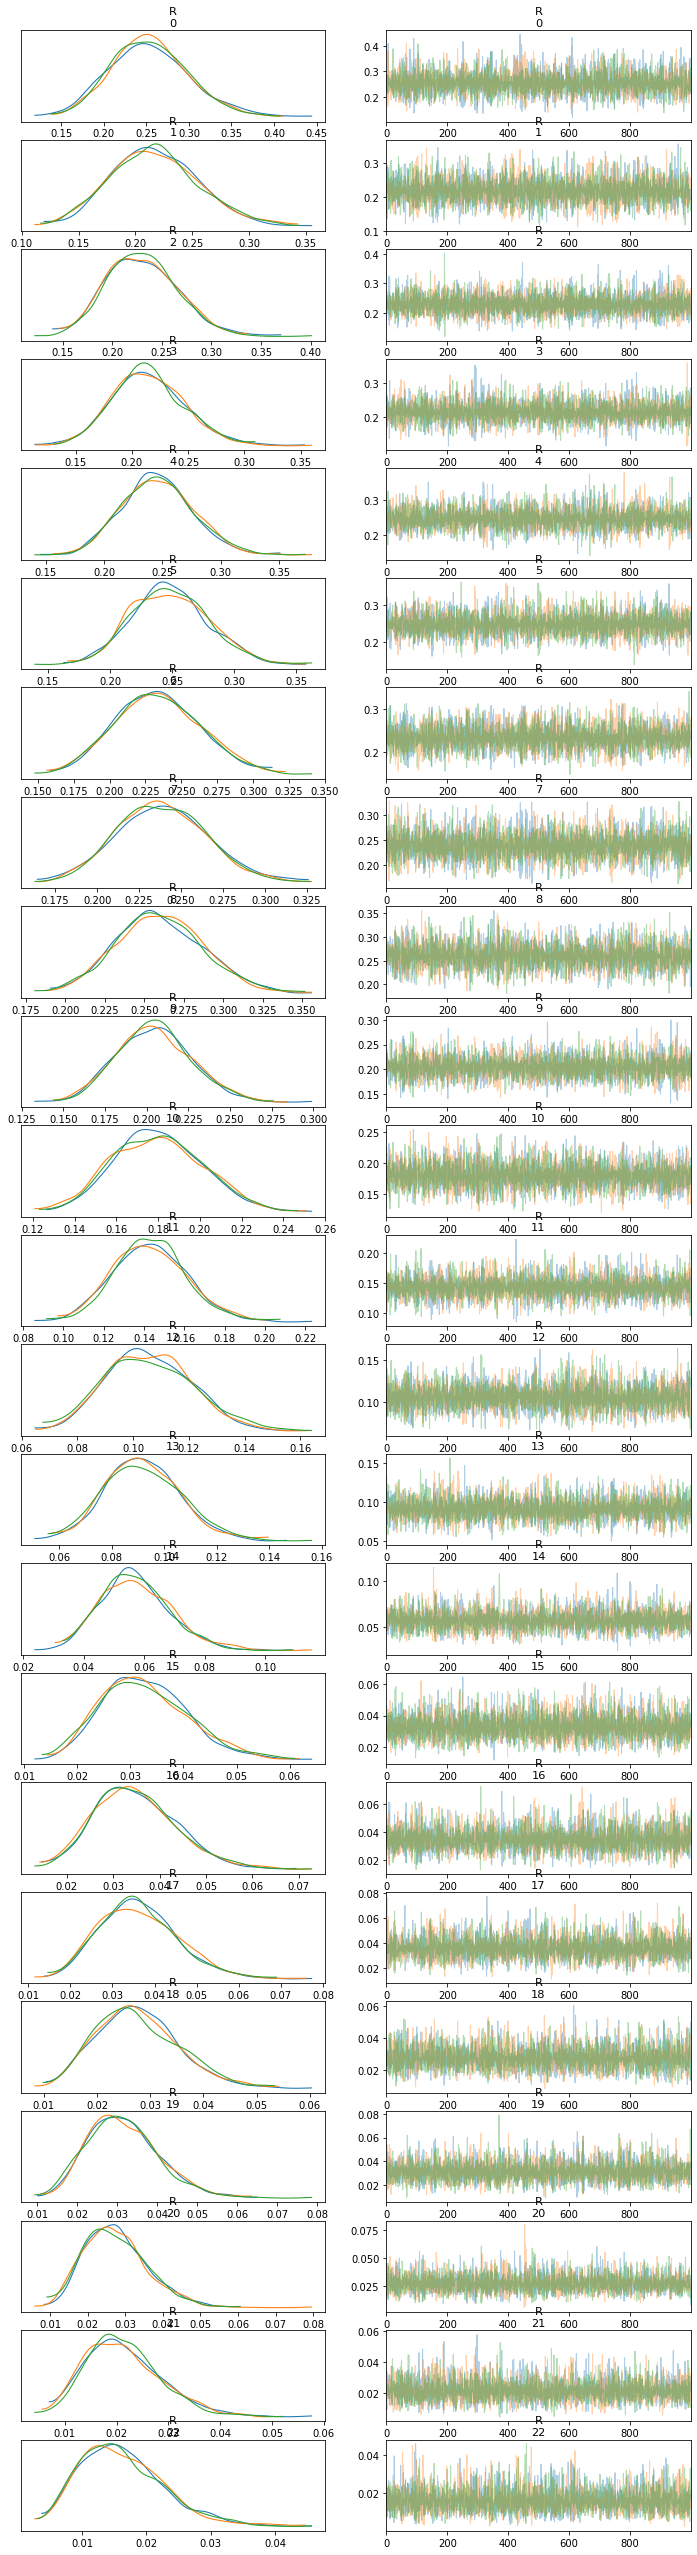

In [8]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [9]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))
exact_multicat_intervals = []

for j in range(num_categories):
    exact_multicat_intervals.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'Mean': np.mean(extended_samples[:, ::thinning] * correc_e[R_t_start:, j][:, None], axis=1),
        'Lower bound CI': np.quantile(extended_samples[:, ::thinning] * correc_e[R_t_start:, j][:, None], 0.025, axis=1),
        'Upper bound CI': np.quantile(extended_samples[:, ::thinning] * correc_e[R_t_start:, j][:, None], 0.975, axis=1),
        'Central Probability': (L1+L2) * [0.95]
    }))

## 2. Imperfect Contact Tracing + Desaggregated data + Poisson Branching process with multiple categories

In [10]:
approx_multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int i, int t, array [,] real aI, array [] real aSI,
        array [,] real C, array [] real transm) {
            real mean;

            mean = 0;
            for(j in 1:n){
                if(t > S) {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[(t-S):(t-1), j], aSI) /
                        normalizing_const(aSI));
                }
                else {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[:(t-1), j], aSI[(S-t+2):]) /
                        normalizing_const(aSI));
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    array [n] real transm; // transmissibility vector
    array [N, n] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for (i in 1:n){
            for(k in (t-tau+1):(t+1)) {
                if (effective_no_infectives(N, S, n, i, k, I, revSI, C, transm) != 0) {
                    I[k, i] ~ poisson (
                        R[t-tau] * effective_no_infectives(
                            N, S, n, i, k, I, revSI, C, transm)); // likelihood
                        }
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

approx_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_6899/4283690943.py:67: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [11]:
posterior = stan.build(
    approx_multicat_model, data=approx_multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   0.244  0.045   0.163    0.331      0.001      0.0    6014.0    2189.0   
R[1]   0.205  0.037   0.137    0.273      0.000      0.0    7281.0    2123.0   
R[2]   0.211  0.033   0.150    0.273      0.000      0.0    5114.0    1898.0   
R[3]   0.197  0.029   0.142    0.251      0.000      0.0    4760.0    1959.0   
R[4]   0.241  0.030   0.184    0.295      0.000      0.0    6130.0    2488.0   
R[5]   0.234  0.028   0.181    0.286      0.000      0.0    6190.0    2186.0   
R[6]   0.218  0.026   0.171    0.268      0.000      0.0    6876.0    2425.0   
R[7]   0.238  0.028   0.186    0.290      0.000      0.0    6449.0    2089.0   
R[8]   0.259  0.029   0.205    0.311      0.000      0.0    6609.0    2427.0   
R[9]   0.223  0.025   0.175    0.269      0.000      0.0    6598.0    1940.0   
R[10]  0.195  0.022   0.157    0.237      0.000      0.0    6361.0    2209.0   
R[11]  0.148  0.020   0.112    0.184      0.000      0.0    5683.0    1827.0   
R[12]  0.123  0.018   0.091    0.158      0.000      0.0    6884.0    2316.0   
R[13]  0.099  0.015   0.073    0.129      0.000      0.0    5857.0    2131.0   
R[14]  0.063  0.012   0.040    0.086      0.000      0.0    6550.0    2000.0   
R[15]  0.036  0.009   0.019    0.053      0.000      0.0    5611.0    2243.0   
R[16]  0.036  0.009   0.020    0.053      0.000      0.0    6614.0    2372.0   
R[17]  0.038  0.010   0.022    0.057      0.000      0.0    6636.0    2286.0   
R[18]  0.029  0.008   0.014    0.044      0.000      0.0    5473.0    2070.0   
R[19]  0.030  0.009   0.015    0.046      0.000      0.0    5294.0    2271.0   
R[20]  0.028  0.009   0.013    0.044      0.000      0.0    7235.0    1863.0   
R[21]  0.021  0.007   0.009    0.035      0.000      0.0    5850.0    2394.0   
R[22]  0.017  0.007   0.005    0.029      0.000      0.0    5774.0    2557.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

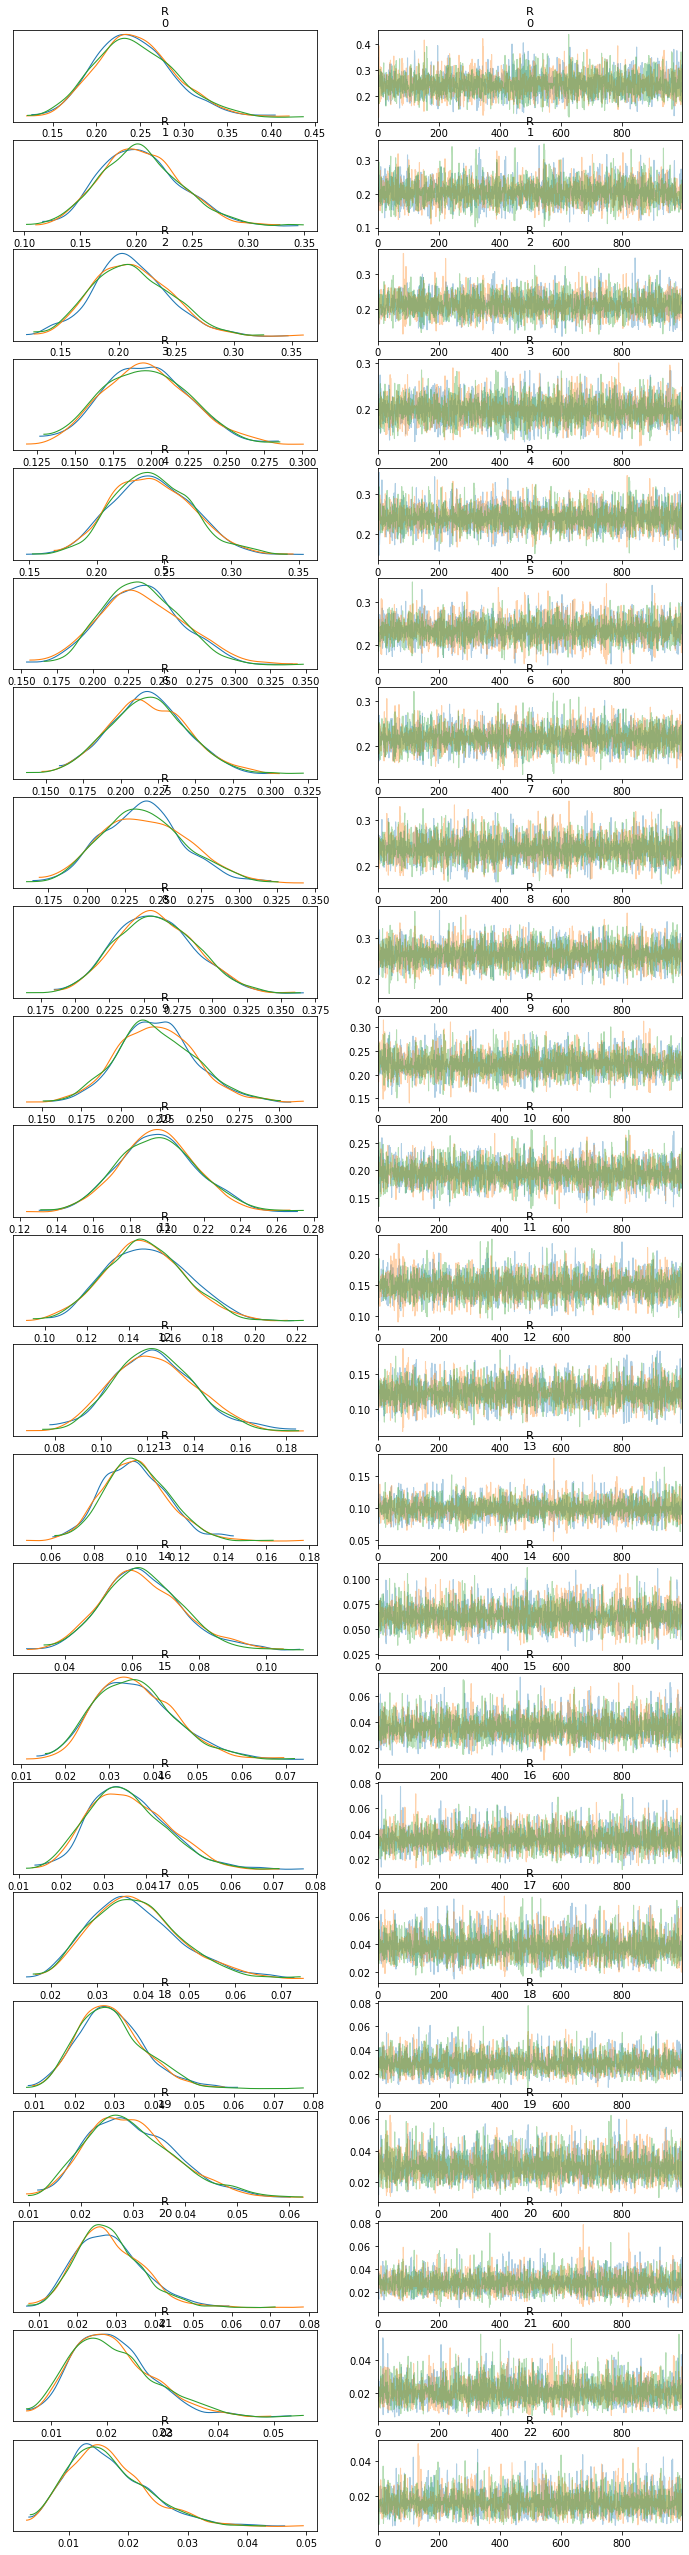

In [12]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [13]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))
approx_multicat_intervals = []

for j in range(num_categories):
    approx_multicat_intervals.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'Mean': np.mean(correc_i[j] * extended_samples[:, ::thinning], axis=1),
        'Lower bound CI': np.quantile(correc_i[j] * extended_samples[:, ::thinning], 0.025, axis=1),
        'Upper bound CI': np.quantile(correc_i[j] * extended_samples[:, ::thinning], 0.975, axis=1),
        'Central Probability': (L1+L2) * [0.95]
    }))

## 3. Imperfect Contact Tracing + Aggregated data + Poisson Branching process with multiple categories

In [14]:
agg_multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int t, array [] real aI, array [] real aSI,
        array [,] real C, array [] real transm, array [] vector ap) {
            real mean;

            mean = 0;
            for(i in 1:n){
                for(j in 1:n){
                    if(t > S) {
                        for(k in (t-S):(t-1)){
                            mean += C[i,j] * transm[j] * ap[k, j] * aI[k] * aSI[S-t+1+k] /
                                normalizing_const(aSI);
                        }
                    }
                    else {
                        for(k in 1:(t-1)){
                            mean += C[i,j] * transm[j] * ap[k, j] * aI[k] * aSI[S-t+1+k] /
                                normalizing_const(aSI);
                        }
                    }
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    array [n] real transm; // transmissibility vector
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
    simplex [n] p[N]; // vector of proportion
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, n, k, I, revSI, C, transm, p) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, n, k, I, revSI, C, transm, p)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
    for(t in 1:N) {
        p[t] ~ dirichlet (rep_vector(1, n)); // prior for p
    }
}
"""

agg_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_6899/1251656915.py:73: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [15]:
posterior = stan.build(
    agg_multicat_model, data=agg_multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate'],
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 46, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 51, column 12: A
    control flow statement depends on parameter(s): p.
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 21, column 24: A
    control flow statement inside function effective_no_infectives depends on
    argument t. At
    '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan',
    line 54, column 33 to column 34, the value of t depends on parameter(s):
    p.
Warn

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
R[0]      0.237  0.055   0.141    0.343      0.002    0.001     945.0   
R[1]      0.198  0.044   0.125    0.282      0.001    0.001     909.0   
R[2]      0.204  0.041   0.134    0.282      0.002    0.001     697.0   
R[3]      0.190  0.038   0.121    0.261      0.001    0.001     843.0   
R[4]      0.232  0.042   0.160    0.310      0.002    0.001     717.0   
...         ...    ...     ...      ...        ...      ...       ...   
p[27, 1]  0.501  0.290   0.056    0.990      0.004    0.004    4700.0   
p[28, 0]  0.493  0.292   0.025    0.965      0.004    0.003    5654.0   
p[28, 1]  0.507  0.292   0.035    0.975      0.004    0.003    5654.0   
p[29, 0]  0.496  0.283   0.060    0.987      0.004    0.003    4533.0   
p[29, 1]  0.504  0.283   0.013    0.940      0.004    0.003    4533.0   

          ess_tail  r_hat  
R[0]        1634.0    1.0  
R[1]        1701.0    1.0  
R[2]        1557.0    1.0  
R[3]        1525.0    1.0  
R[4]        1266.0    1.0  
...            ...    ...  
p[27, 1]    1548.0    1.0  
p[28, 0]    2002.0    1.0  
p[28, 1]    2002.0    1.0  
p[29, 0]    2107.0    1.0  
p[29, 1]    2107.0    1.0  

[83 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

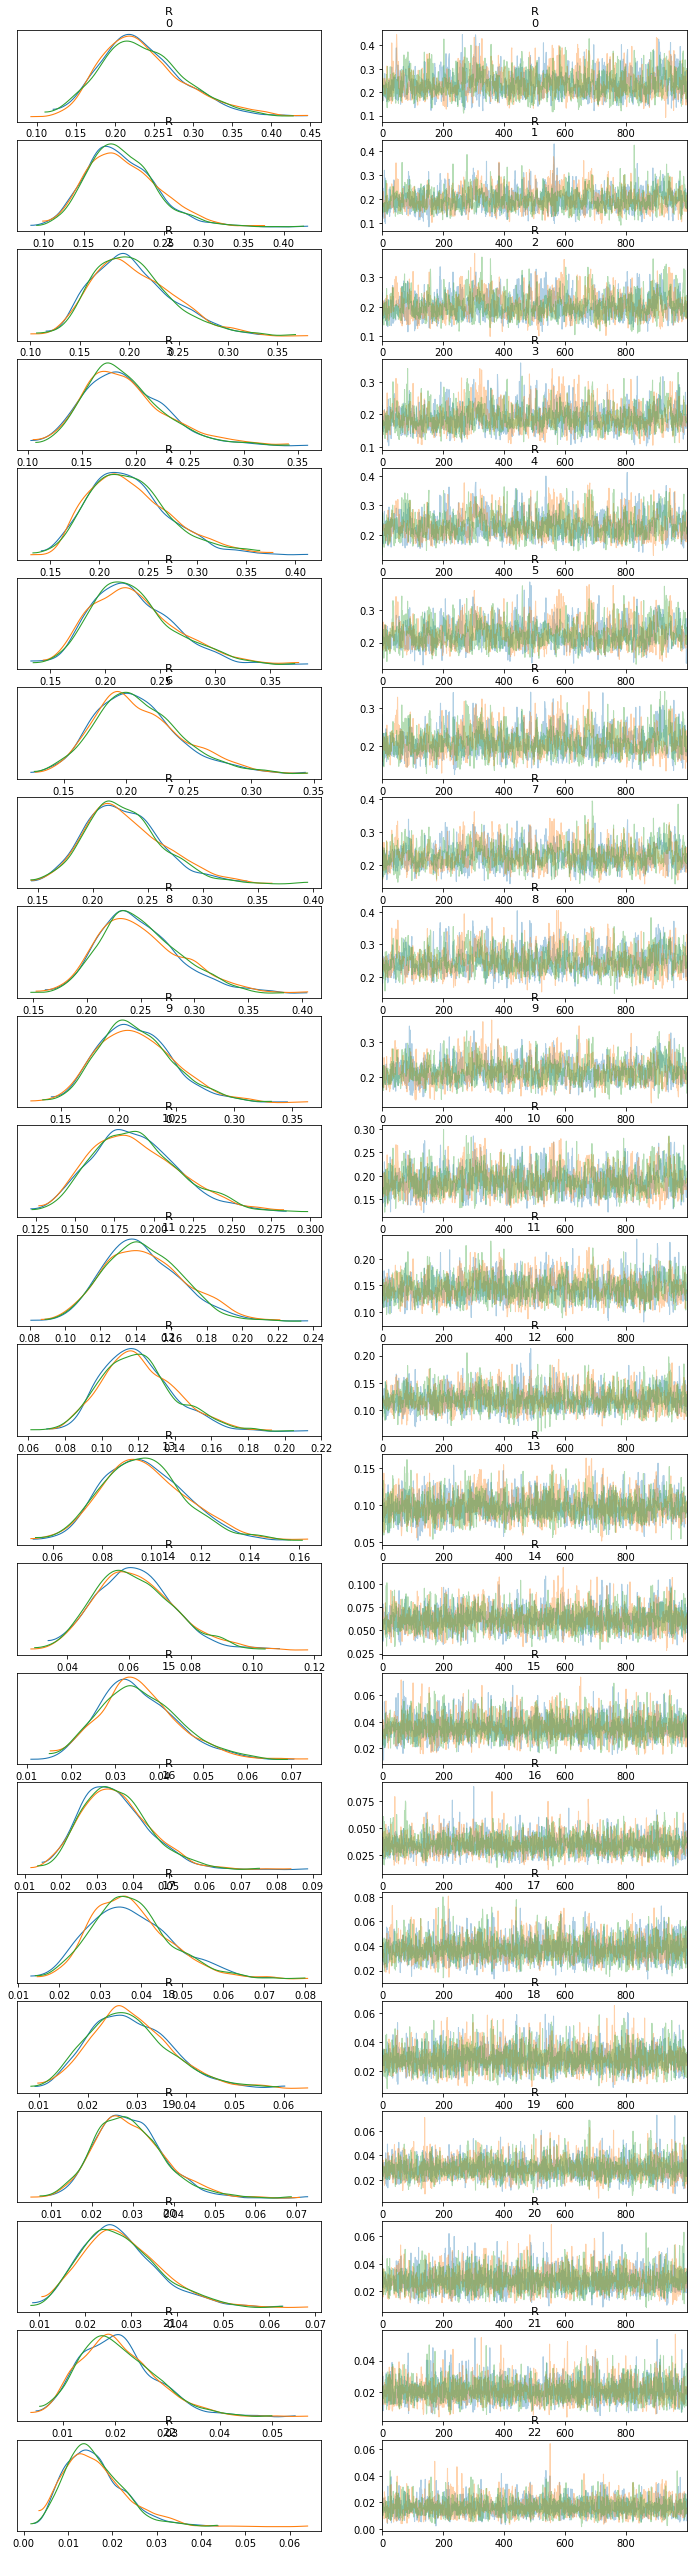

In [16]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

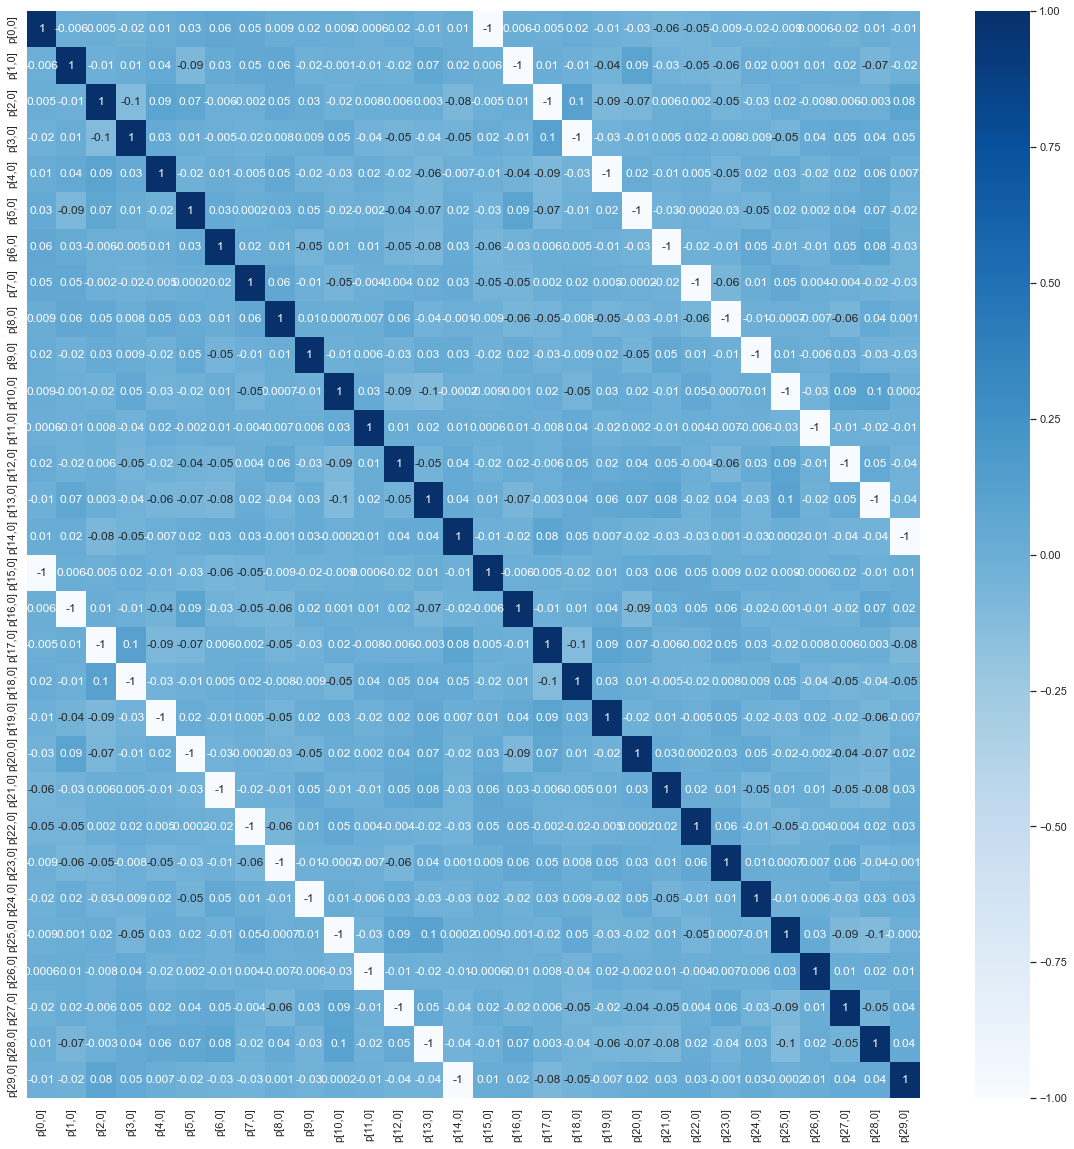

In [17]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
p_chain_samples = fit._draws[(num_timepoints - R_t_start +7)::num_categories, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = p_chain_samples.shape

extended_p_samples = np.concatenate((
    p_chain_samples[:, :, 0],
    p_chain_samples[:, :, 1],
    p_chain_samples[:, :, 2]), axis=1)

df = pd.DataFrame(
    np.transpose(extended_p_samples),
    columns=[
        'p[{},0]'.format(_)
        for _ in range(num_timepoints)])

plt.figure(figsize=(20,20))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [18]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:(num_timepoints - R_t_start +7), 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))
agg_multicat_intervals = []

for j in range(num_categories):
    agg_multicat_intervals.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'Mean': np.mean(correc_i[j] * extended_samples[:, ::thinning], axis=1),
        'Lower bound CI': np.quantile(correc_i[j] * extended_samples[:, ::thinning], 0.025, axis=1),
        'Upper bound CI': np.quantile(correc_i[j] * extended_samples[:, ::thinning], 0.975, axis=1),
        'Central Probability': (L1+L2) * [0.95]
    }))

## 4. Aggregated data + Poisson Branching process

In [19]:
poisson_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_6899/1887272557.py:54: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [20]:
posterior = stan.build(
    poisson_model, data=poisson_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   8% (500/6000)
Sampling:  12% (700/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  22% (1300/6000)
Sampling:  27% (1600/6000)
Sampling:  32% (1900/6000)
Sampling:  35% (2100/6000)
Sampling:  38% (2300/6000)
Sampling:  42% (2500/6000)
Sampling:  45% (2700/6000)
Sampling:  63% (3800/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001208 seconds
  1000 transitions using 10 leapfrog steps per transition would take 12.08 seconds.
  Adjust your expectations accordingly!
  Informational Message: The curre

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   1.681  0.308   1.106    2.251      0.004    0.003    6726.0    2208.0   
R[1]   1.402  0.243   0.974    1.851      0.003    0.002    5601.0    2178.0   
R[2]   1.445  0.223   1.008    1.847      0.003    0.002    7152.0    2685.0   
R[3]   1.355  0.204   0.976    1.753      0.002    0.002    7477.0    2255.0   
R[4]   1.656  0.208   1.303    2.062      0.002    0.002    7036.0    2231.0   
R[5]   1.609  0.197   1.253    2.001      0.002    0.002    7607.0    2096.0   
R[6]   1.498  0.183   1.156    1.853      0.002    0.002    6971.0    2591.0   
R[7]   1.622  0.191   1.259    1.957      0.002    0.002    6082.0    1907.0   
R[8]   1.768  0.192   1.416    2.133      0.002    0.002    7425.0    2133.0   
R[9]   1.521  0.169   1.218    1.840      0.002    0.001    6710.0    2058.0   
R[10]  1.328  0.155   1.062    1.634      0.002    0.001    7435.0    2322.0   
R[11]  1.006  0.135   0.750    1.252      0.002    0.001    7237.0    2388.0   
R[12]  0.831  0.120   0.621    1.071      0.001    0.001    6958.0    2126.0   
R[13]  0.674  0.107   0.477    0.876      0.001    0.001    6992.0    2170.0   
R[14]  0.425  0.085   0.266    0.584      0.001    0.001    6863.0    2153.0   
R[15]  0.242  0.061   0.135    0.359      0.001    0.001    7213.0    2252.0   
R[16]  0.239  0.061   0.132    0.355      0.001    0.001    6296.0    2068.0   
R[17]  0.255  0.061   0.141    0.365      0.001    0.001    6362.0    2221.0   
R[18]  0.193  0.056   0.094    0.299      0.001    0.001    6215.0    1863.0   
R[19]  0.197  0.056   0.098    0.304      0.001    0.001    8076.0    1608.0   
R[20]  0.184  0.057   0.086    0.293      0.001    0.001    7201.0    2013.0   
R[21]  0.140  0.048   0.057    0.233      0.001    0.000    7004.0    2182.0   
R[22]  0.108  0.045   0.033    0.193      0.001    0.000    6664.0    2001.0   

       r_hat  
R[0]    1.00  
R[1]    1.00  
R[2]    1.00  
R[3]    1.00  
R[4]    1.00  
R[5]    1.00  
R[6]    1.00  
R[7]    1.00  
R[8]    1.00  
R[9]    1.01  
R[10]   1.00  
R[11]   1.00  
R[12]   1.00  
R[13]   1.00  
R[14]   1.00  
R[15]   1.00  
R[16]   1.00  
R[17]   1.00  
R[18]   1.00  
R[19]   1.00  
R[20]   1.00  
R[21]   1.00  
R[22]   1.00

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

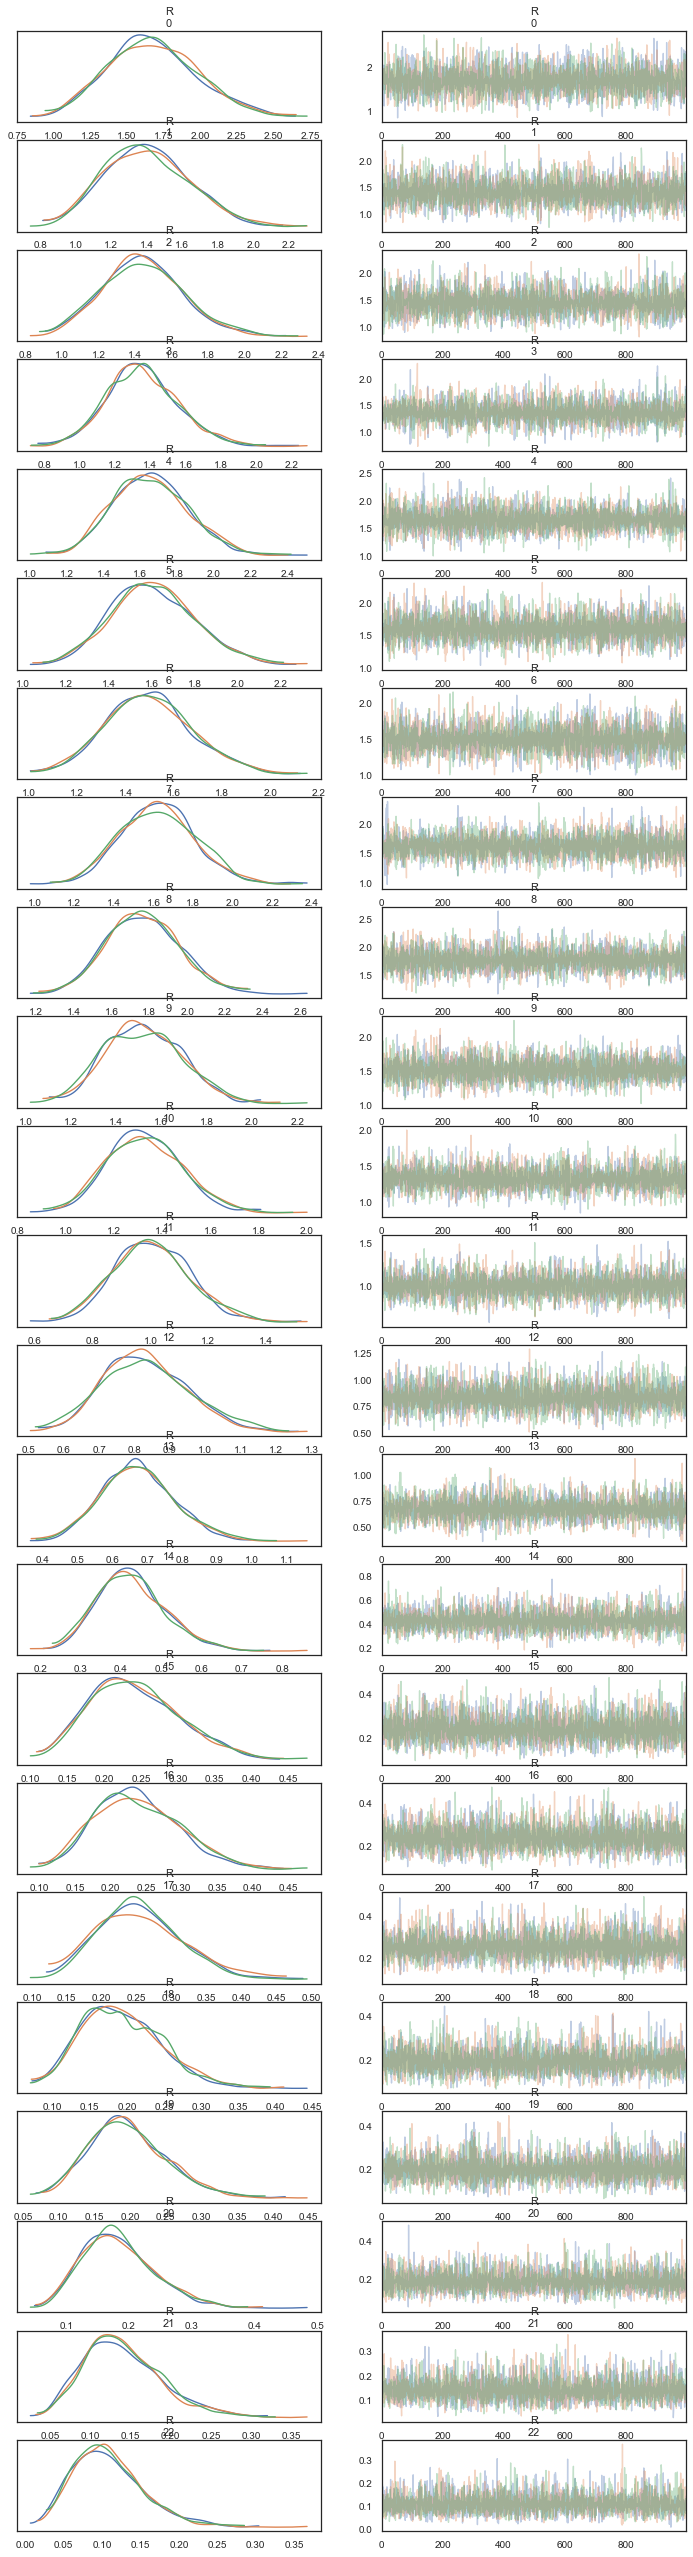

In [21]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [22]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [23]:
fig = ReproductionNumberPlot()

for j in range(num_categories):
    fig.add_ground_truth_rt(ground_truth[j], shape=[None, 'dash'][j])
    fig.add_interval_rt(exact_multicat_intervals[j], shape=[None, 'dash'][j], model_type='exact_contact_tracing agg_multi_categorical')
    fig.add_interval_rt(approx_multicat_intervals[j], colour='red', shape=[None, 'dash'][j], model_type='agg_multi_categorical')
    fig.add_interval_rt(agg_multicat_intervals[j], colour='orange', shape=[None, 'dash'][j], model_type='desagg_multi_categorical')
fig.add_interval_rt(pois_intervals, colour='deepskyblue', model_type='uniform poisson term')
    
fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

